# Start-sensitivity analysis (MSE vs uncertainty)

This notebook compares **mean performance across starts** (average across permutations) vs **best-start performance** (oracle upper bound) for Plan B runs.

Definitions (per task + policy):
- **Mean across starts**: average score across permutations (each permutation = a start image).
- **Best start**: max score across permutations.
- **Gap**: best - mean.


In [1]:
from pathlib import Path
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

REPO_ROOT = Path('.').resolve()
if not (REPO_ROOT / 'experiments').exists():
    REPO_ROOT = REPO_ROOT.parent
sys.path.insert(0, str(REPO_ROOT))

from experiments.analysis.planb_utils import load_planb_summaries


In [2]:
# Config
REPO_ROOT = Path('.').resolve()
if not (REPO_ROOT / 'experiments').exists():
    REPO_ROOT = REPO_ROOT.parent
PROCEDURES = ['random_v_MSE_v2', 'random_vs_uncertainty_v2']
ABLATION = 'pretrained_baseline'
METRIC = 'iterations_used'  # e.g., final_dice, initial_dice, iterations_used
FAMILIES = None  # e.g., ['ACDC', 'BTCV']
LOWER_IS_BETTER = True  # set True for metrics like iterations_used


In [3]:
def load_planb_rows(repo_root, *, procedure, ablation, metric, families=None):
    df = load_planb_summaries(
        repo_root=repo_root,
        procedure=procedure,
        ablation=ablation,
        dataset=None,
        filename='subset_support_images_summary.csv',
        allow_root_fallback=True,
    )
    if families is not None:
        df = df[df['family'].isin(families)]
    if df.empty:
        raise FileNotFoundError(f'No Plan B summaries found for {procedure}/{ablation}')
    if metric not in df.columns:
        raise ValueError(f'Missing {metric} in Plan B summary for {procedure}.')
    keep = df[[
        'family', 'task_name', 'policy_name',
        'subset_index', 'permutation_index', 'image_index', 'image_id', metric
    ]].copy()
    keep = keep.rename(columns={
        'task_name': 'task',
        'policy_name': 'policy',
        metric: 'metric_value',
    })
    keep['procedure'] = procedure
    return keep


In [4]:
def summarise_start_sensitivity(df, metric, *, lower_is_better=False):
    keys = ['procedure', 'family', 'task', 'policy', 'subset_index', 'permutation_index']
    per_perm = (
        df.groupby(keys, as_index=False)['metric_value']
        .mean()
        .rename(columns={'metric_value': 'perm_score'})
    )
    start_map = (
        df[df['image_index'] == 0]
        .groupby(keys, as_index=False)['image_id']
        .first()
        .rename(columns={'image_id': 'start_image_id'})
    )
    per_perm = per_perm.merge(start_map, on=keys, how='left')

    subset_keys = ['procedure', 'family', 'task', 'policy', 'subset_index']
    agg = per_perm.groupby(subset_keys, as_index=False)['perm_score']
    if lower_is_better:
        per_subset = agg.agg(
            mean_start='mean',
            best_start='min',
            worst_start='max',
            n_perm='count',
        )
    else:
        per_subset = agg.agg(
            mean_start='mean',
            best_start='max',
            worst_start='min',
            n_perm='count',
        )
    per_subset['gap'] = per_subset['best_start'] - per_subset['mean_start']

    task_keys = ['procedure', 'family', 'task', 'policy']
    per_task = (
        per_subset.groupby(task_keys, as_index=False)
        .agg(
            mean_start=('mean_start', 'mean'),
            best_start=('best_start', 'mean'),
            worst_start=('worst_start', 'mean'),
            n_subsets=('subset_index', 'nunique'),
            n_perm_avg=('n_perm', 'mean'),
        )
    )
    per_task['gap'] = per_task['best_start'] - per_task['mean_start']

    family_keys = ['procedure', 'family', 'policy']
    per_family = (
        per_task.groupby(family_keys, as_index=False)
        .agg(
            mean_start=('mean_start', 'mean'),
            best_start=('best_start', 'mean'),
            worst_start=('worst_start', 'mean'),
            n_tasks=('task', 'nunique'),
        )
    )
    per_family['gap'] = per_family['best_start'] - per_family['mean_start']

    return per_perm, per_subset, per_task, per_family


In [5]:
all_rows = []
for procedure in PROCEDURES:
    df = load_planb_rows(
        REPO_ROOT,
        procedure=procedure,
        metric=METRIC,
        ablation=ABLATION,
        families=FAMILIES,
    )
    all_rows.append(df)

raw = pd.concat(all_rows, ignore_index=True)
raw.head()


,family,task,policy,subset_index,permutation_index,image_index,image_id,metric_value,procedure
0,ACDC,ACDC_Challenge2017_MRI_2_label0_maxslice_idx624,mse_alternate_start_max,0,0,0,47,20,random_v_MSE_v2
1,ACDC,ACDC_Challenge2017_MRI_2_label0_maxslice_idx624,mse_alternate_start_max,0,0,1,9,0,random_v_MSE_v2
2,ACDC,ACDC_Challenge2017_MRI_2_label0_maxslice_idx624,mse_alternate_start_max,0,0,2,57,2,random_v_MSE_v2
3,ACDC,ACDC_Challenge2017_MRI_2_label0_maxslice_idx624,mse_alternate_start_max,0,0,3,17,1,random_v_MSE_v2
4,ACDC,ACDC_Challenge2017_MRI_2_label0_maxslice_idx624,mse_alternate_start_max,0,0,4,25,20,random_v_MSE_v2


In [6]:
per_perm, per_subset, per_task, per_family = summarise_start_sensitivity(
    raw, METRIC, lower_is_better=LOWER_IS_BETTER
)

# Family-level summary (mean/best/gap across tasks)
summary = per_family.sort_values(['procedure', 'family', 'policy'])
summary


,procedure,family,policy,mean_start,best_start,worst_start,n_tasks,gap
0,random_v_MSE_v2,ACDC,mse_alternate_start_max,11.387500,10.896667,11.843333,6,-0.490833
1,random_v_MSE_v2,ACDC,mse_alternate_start_min,11.392833,10.883333,11.880000,6,-0.509500
2,random_v_MSE_v2,ACDC,mse_max,11.383833,10.895000,11.816667,6,-0.488833
3,random_v_MSE_v2,ACDC,mse_min,11.411833,10.936667,11.846667,6,-0.475167
4,random_v_MSE_v2,ACDC,random,11.386917,10.638333,12.120000,6,-0.748583
5,random_v_MSE_v2,BTCV,mse_alternate_start_max,3.182850,2.619500,4.029500,20,-0.563350
6,random_v_MSE_v2,BTCV,mse_alternate_start_min,3.181100,2.601500,3.908000,20,-0.579600
7,random_v_MSE_v2,BTCV,mse_max,3.167900,2.576500,3.902500,20,-0.591400
8,random_v_MSE_v2,BTCV,mse_min,3.164550,2.604500,3.924500,20,-0.560050
9,random_v_MSE_v2,BTCV,random,3.164585,2.280500,4.669000,20,-0.884085


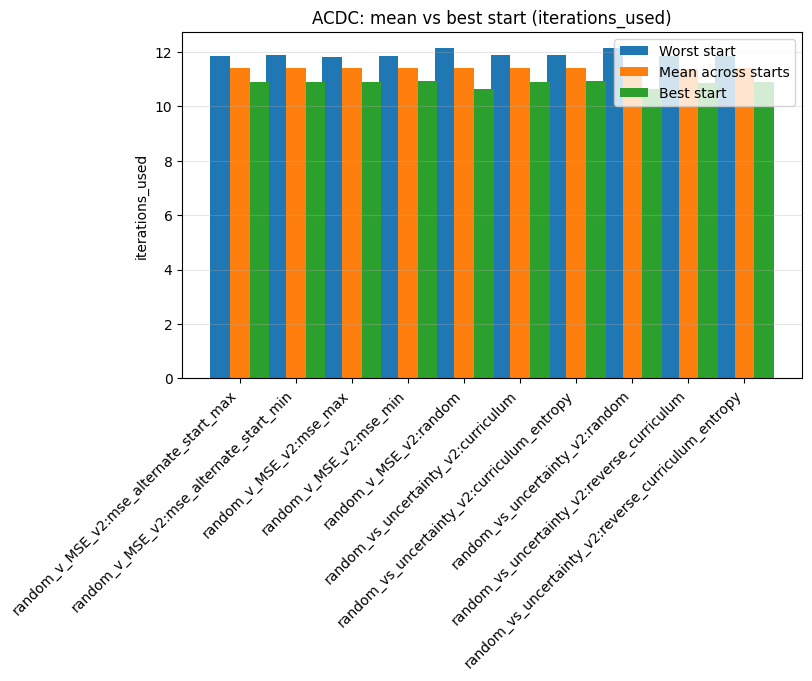

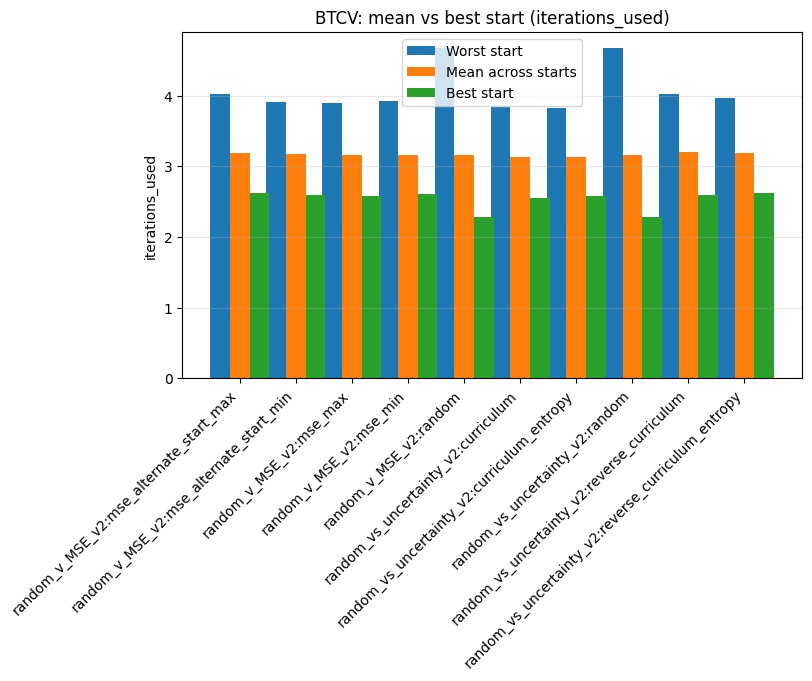

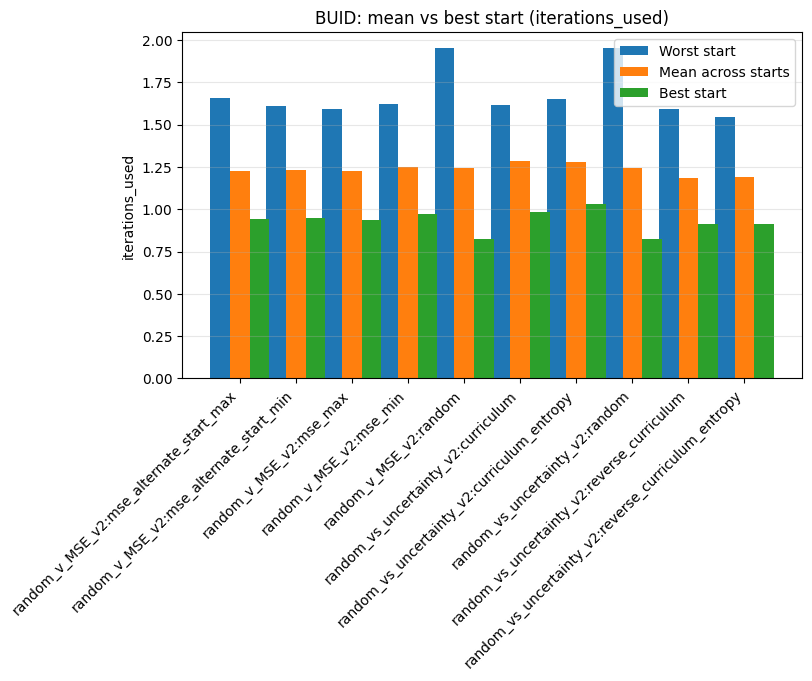

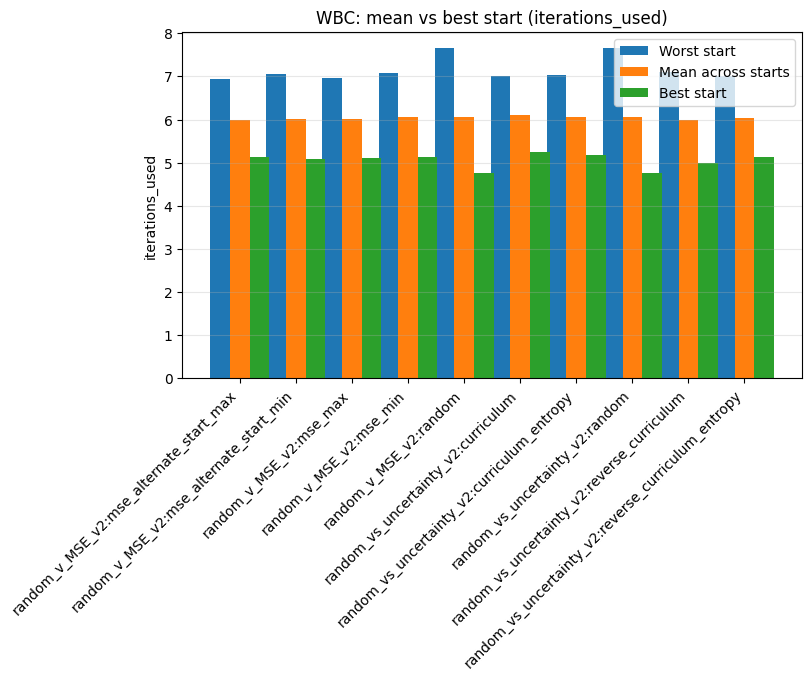

In [7]:
def plot_family(summary_df, family, metric):
    sub = summary_df[summary_df['family'] == family].copy()
    if sub.empty:
        print(f'No data for {family}')
        return
    sub = sub.sort_values(['procedure', 'policy'])
    labels = sub['procedure'] + ':' + sub['policy']
    x = np.arange(len(sub))
    width = 0.35

    fig, ax = plt.subplots(figsize=(max(8, len(sub) * 0.5), 4.5))
    ax.bar(x - width, sub['worst_start'], width, label='Worst start')
    ax.bar(x, sub['mean_start'], width, label='Mean across starts')
    ax.bar(x + width, sub['best_start'], width, label='Best start')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_ylabel(metric)
    ax.set_title(f'{family}: mean vs best start ({metric})')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    plt.show()

# Example: plot one family
for fam in summary['family'].unique():
    plot_family(summary, fam, METRIC)
